In [1]:
import tensorflow as tf

In [2]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

## Instance Segmentation con Mask R-CNN (OpenCV)

In [1]:
%%capture
!wget http://download.tensorflow.org/models/object_detection/mask_rcnn_inception_v2_coco_2018_01_28.tar.gz
!tar zxvf mask_rcnn_inception_v2_coco_2018_01_28.tar.gz
!wget https://raw.githubusercontent.com/spmallick/learnopencv/master/Mask-RCNN/mscoco_labels.names -O mscoco_labels.names
!wget https://raw.githubusercontent.com/spmallick/learnopencv/master/Mask-RCNN/colors.txt -O colors.txt
!wget https://raw.githubusercontent.com/spmallick/learnopencv/master/Mask-RCNN/mask_rcnn_inception_v2_coco_2018_01_28.pbtxt -O mask_rcnn_inception_v2_coco_2018_01_28.pbtxt


In [3]:
import numpy as np
import cv2 as cv
import time
import random
from matplotlib import pyplot as plt

In [4]:


# Umbral de confianza para las detecciones
confThreshold = 0.5
# Umbral para las máscaras de segmentación
maskThreshold = 0.3

# Cargar los nombres de las clases de MSCOCO
classesFile = "mscoco_labels.names"
classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

# Cargar los colores para visualizar las detecciones
colorsFile = "colors.txt"
colors = []
with open(colorsFile, 'rt') as f:
    colorsStr = f.read().rstrip('\n').split('\n')
    for i in range(len(colorsStr)):
        rgb = colorsStr[i].split(' ')
        color = np.array([float(rgb[0]), float(rgb[1]), float(rgb[2])])
        colors.append(color)

# Archivos de configuración y pesos del modelo Mask R-CNN
textGraph = "./mask_rcnn_inception_v2_coco_2018_01_28.pbtxt"
modelWeights = "./mask_rcnn_inception_v2_coco_2018_01_28/frozen_inference_graph.pb"

# Cargar la red
net = cv.dnn.readNetFromTensorflow(modelWeights, textGraph)
net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv.dnn.DNN_TARGET_CPU)

# Cargar la imagen y obtener sus dimensiones
image = cv.imread('objetos5.jpeg')
(H, W) = image.shape[:2]

# Crear un blob de la imagen y realizar una pasada hacia adelante con Mask R-CNN
blob = cv.dnn.blobFromImage(image, swapRB=True, crop=False)
net.setInput(blob)
start = time.time()
(boxes, masks) = net.forward(["detection_out_final", "detection_masks"])
end = time.time()

# Información de tiempo y formas de las detecciones y máscaras
print("[INFO] Mask R-CNN tomó {:.6f} segundos en procesar la imagen".format(end - start))
print("[INFO] Forma de boxes: {}".format(boxes.shape))
print("[INFO] Forma de masks: {}".format(masks.shape))


[INFO] Mask R-CNN tomó 6.665559 segundos en procesar la imagen
[INFO] Forma de boxes: (1, 1, 100, 7)
[INFO] Forma de masks: (100, 90, 15, 15)


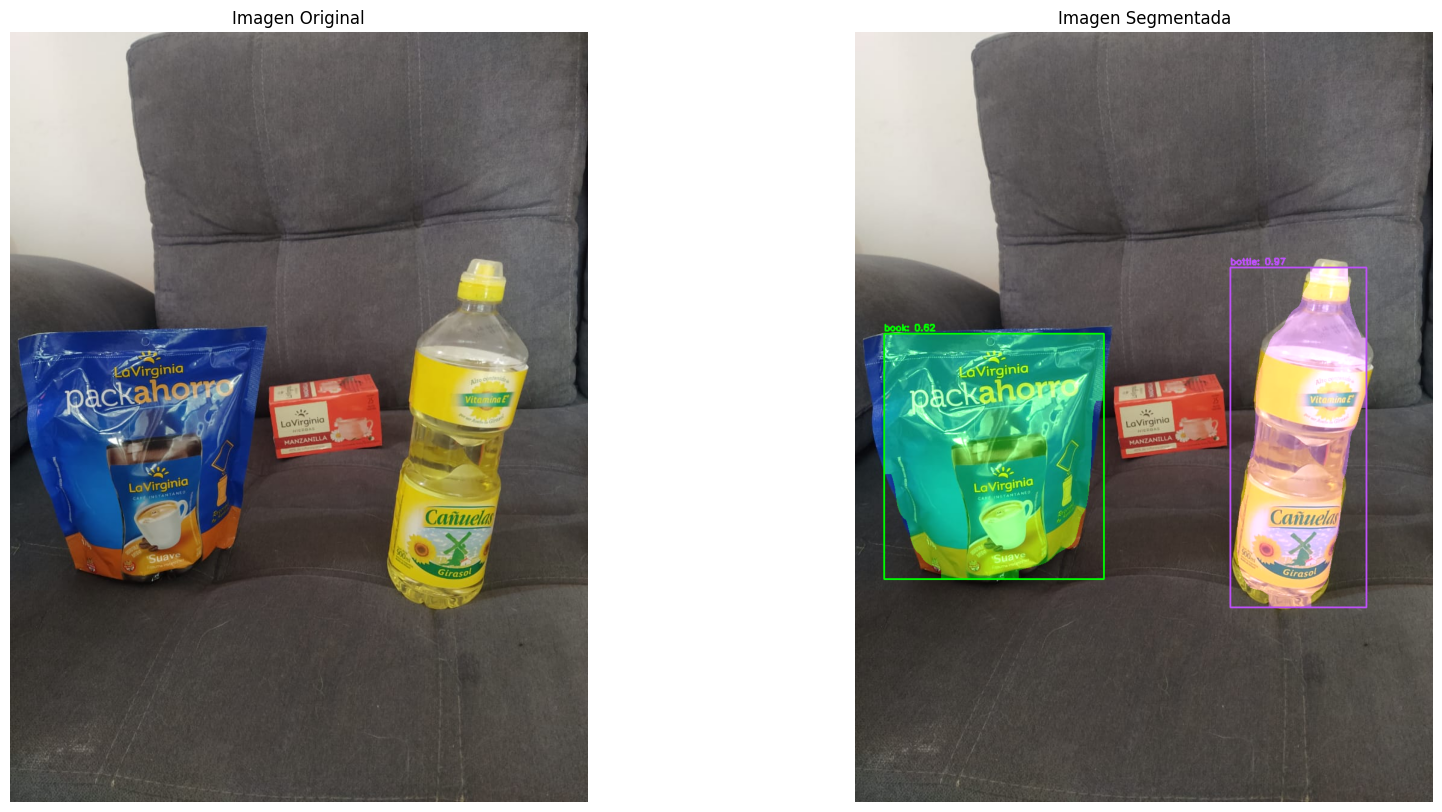

In [5]:
# Creamos una copia de la imagen original, para dibujar las máscaras
output_image = image.copy()

for i in range(0, boxes.shape[2]):
    confidence = boxes[0, 0, i, 2]
    if confidence > confThreshold:
        classId = int(boxes[0, 0, i, 1])
        box = boxes[0, 0, i, 3:7] * np.array([W, H, W, H])
        (startX, startY, endX, endY) = box.astype("int")

        # Redimensiona la máscara para que se ajuste a la caja delimitadora y la convierte en uint8
        mask = masks[i, classId]
        mask = cv.resize(mask, (endX - startX, endY - startY))
        mask = (mask > maskThreshold).astype("uint8")

        # Extrae la región de interés (ROI) usando las coordenadas de la caja delimitadora
        roi = output_image[startY:endY, startX:endX]

        # Crea una imagen de color sólido para la máscara
        color = random.choice(colors)
        color_mask = np.zeros_like(roi)
        color_mask[mask == 1] = color

        # Mezcla la imagen de color con la ROI utilizando la máscara
        roi = cv.addWeighted(roi, 1, color_mask, 0.4, 0)

        # Vuelve a colocar la ROI en la imagen original
        output_image[startY:endY, startX:endX] = roi

        # Dibuja la caja delimitadora
        cv.rectangle(output_image, (startX, startY), (endX, endY), color, 2)

        # Consigue el nombre de la clase y el color correspondiente
        classId = int(boxes[0, 0, i, 1])
        className = classes[classId]

        # Dibuja el rectángulo de la caja delimitadora y la etiqueta de la clase
        label = f"{className}: {confidence:.2f}"
        cv.rectangle(output_image, (startX, startY), (endX, endY), color, 2)
        cv.putText(output_image, label, (startX, startY - 5), cv.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)


# Configurar los subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Mostrar la imagen original
axes[0].imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
axes[0].set_title('Imagen Original')
axes[0].axis('off')  # Ocultar los ejes

# Mostrar la imagen segmentada
axes[1].imshow(cv.cvtColor(output_image, cv.COLOR_BGR2RGB))
axes[1].set_title('Imagen Segmentada')
axes[1].axis('off')  # Ocultar los ejes

# Mostrar ambas imágenes
plt.show()


Usando Mask R-CNN (OpenCV) se detecta dos objeto sobre tres y no estaria haciedo bien los bundig box, podemos ver como parte del objeto queda por fuera del bunding box. La segmentacion tampoco es perfecta no le hace el contorno correctamente a los objetos.  

## Instance Segmentation con modelo PointRend Resnet50 (PixelLib)

In [6]:
%%capture
!pip install pixellib torchvision
# Instance segmentation model
!wget "https://github.com/ayoolaolafenwa/PixelLib/releases/download/0.2.0/pointrend_resnet50.pkl" -O pointrend_resnet50.pkl

  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


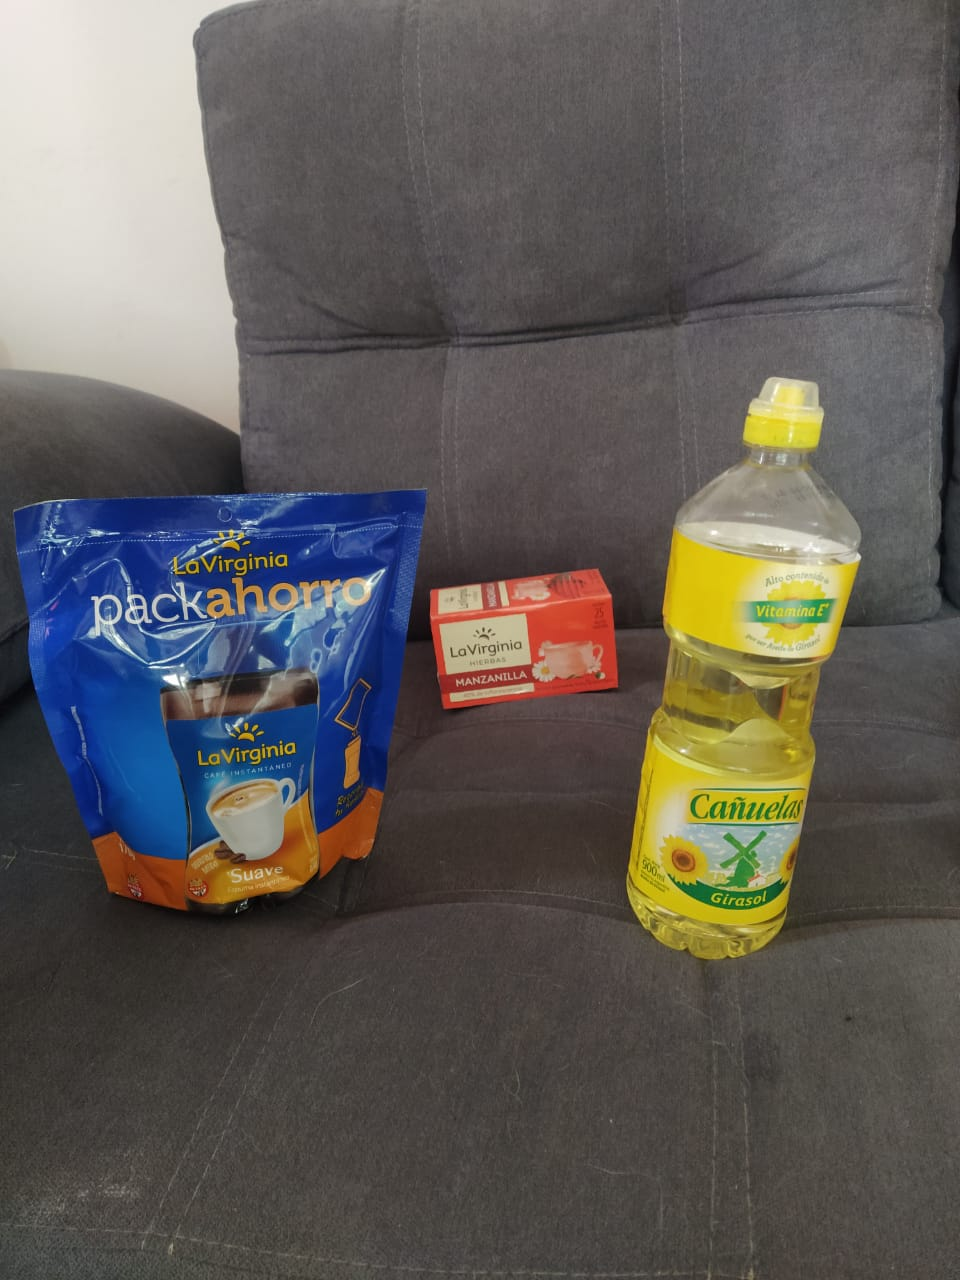

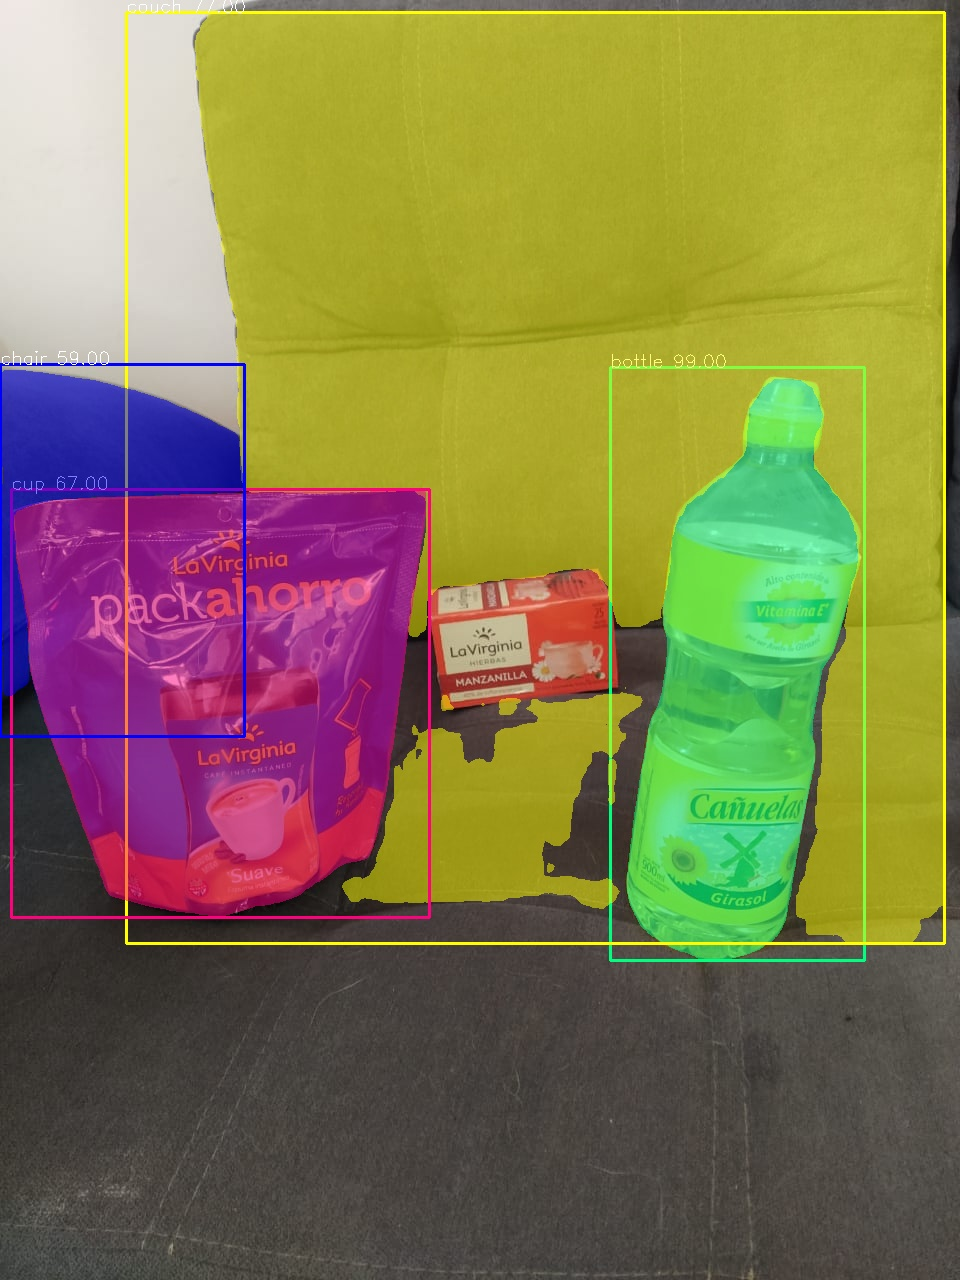

In [11]:
# Importación de las bibliotecas necesarias
import pixellib
from pixellib.torchbackend.instance import instanceSegmentation
from IPython.display import Image

# Creación de una instancia del modelo de segmentación
ins = instanceSegmentation()

# Carga del modelo preentrenado
ins.load_model("pointrend_resnet50.pkl")

# Segmentación de la imagen y guardado de la imagen segmentada con las cajas delimitadoras
ins.segmentImage("objetos5.jpeg", show_bboxes=True, output_image_name="objetos5_segmented.jpeg")

# Muestra la imagen original
display(Image(filename="objetos5.jpeg"))

# Muestra la imagen segmentada
display(Image(filename="objetos5_segmented.jpeg"))


Con  el modelo PointRend Resnet50 vemos que se detecta mas objetos, hasta esta detectando el sofa con un buen nivel de cofianza. Y los bundig box estan correctamente tomando en el paquete de caffe y la bottella. La segmentancion es perfecta en la bottele y paquete de caje. 

## Semantic Segmentation con modelo DeepLabV3m (Torchvision)

In [12]:
%%capture
!pip install torchvision
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
model.eval()

In [13]:
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
import torch

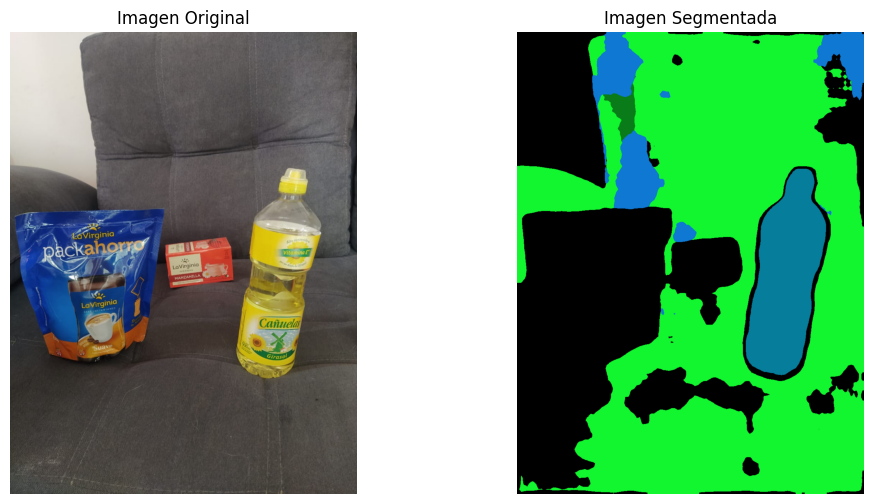

In [14]:
# Carga y procesa la imagen
input_image = Image.open("objetos5.jpeg").convert("RGB").convert("RGB")

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)  # crea un mini-batch como espera el modelo

# Mueve el input y el modelo a GPU para mayor velocidad si está disponible
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)['out'][0]
output_predictions = output.argmax(0)

# Crea una paleta de colores, seleccionando un color para cada clase
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

# Genera la imagen de segmentación semántica
r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size)
r.putpalette(colors)

# Muestra la imagen original y la segmentada lado a lado
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer subplot
plt.imshow(input_image)
plt.title('Imagen Original')
plt.axis('off')  # Oculta los ejes

plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo subplot
plt.imshow(r)
plt.title('Imagen Segmentada')
plt.axis('off')  # Oculta los ejes

plt.show()

El modelo DeepLabV3m segmenta bien la bottela, detecta el sofa y lo segmenta pero no detecta el cafe y lo pone como fondo. 

## Instance Segmentation con YoloV8 (Ultralytics)

In [18]:
%%capture
!pip install ultralytics==8.0.196

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
YOLOv8s-seg summary (fused): 195 layers, 11810560 parameters, 0 gradients, 42.6 GFLOPs

image 1/1 /content/objetos5.jpeg: 640x480 1 bottle, 2252.9ms
Speed: 44.1ms preprocess, 2252.9ms inference, 11.8ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs/segment/predict4
💡 Learn more at https://docs.ultralytics.com/modes/predict


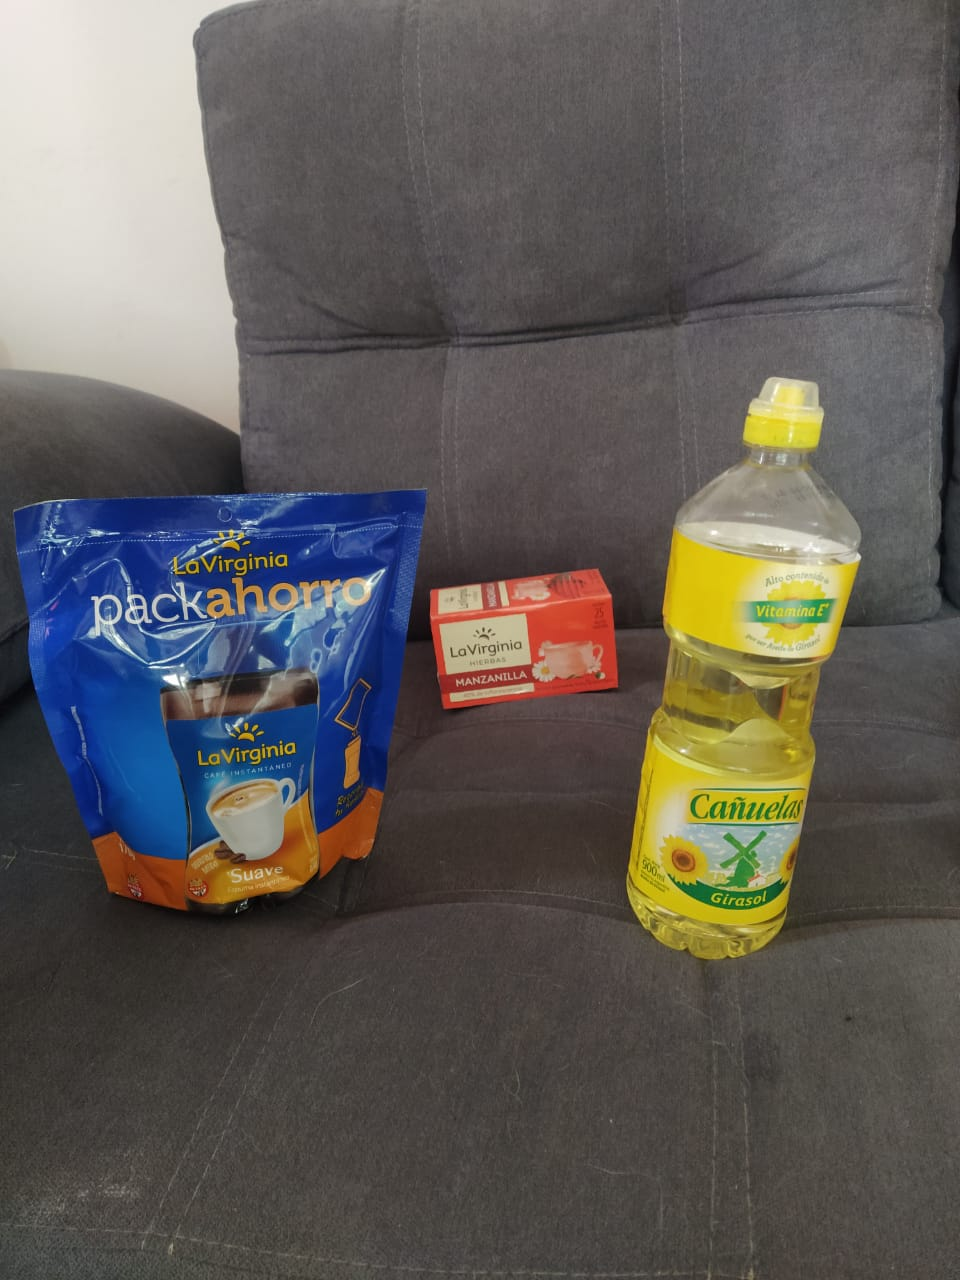

In [23]:
!yolo task=segment mode=predict model=yolov8s-seg.pt conf=0.55 source='objetos5.jpeg' save=true
from IPython.display import Image
Image(filename='objetos5.jpeg', height=600)

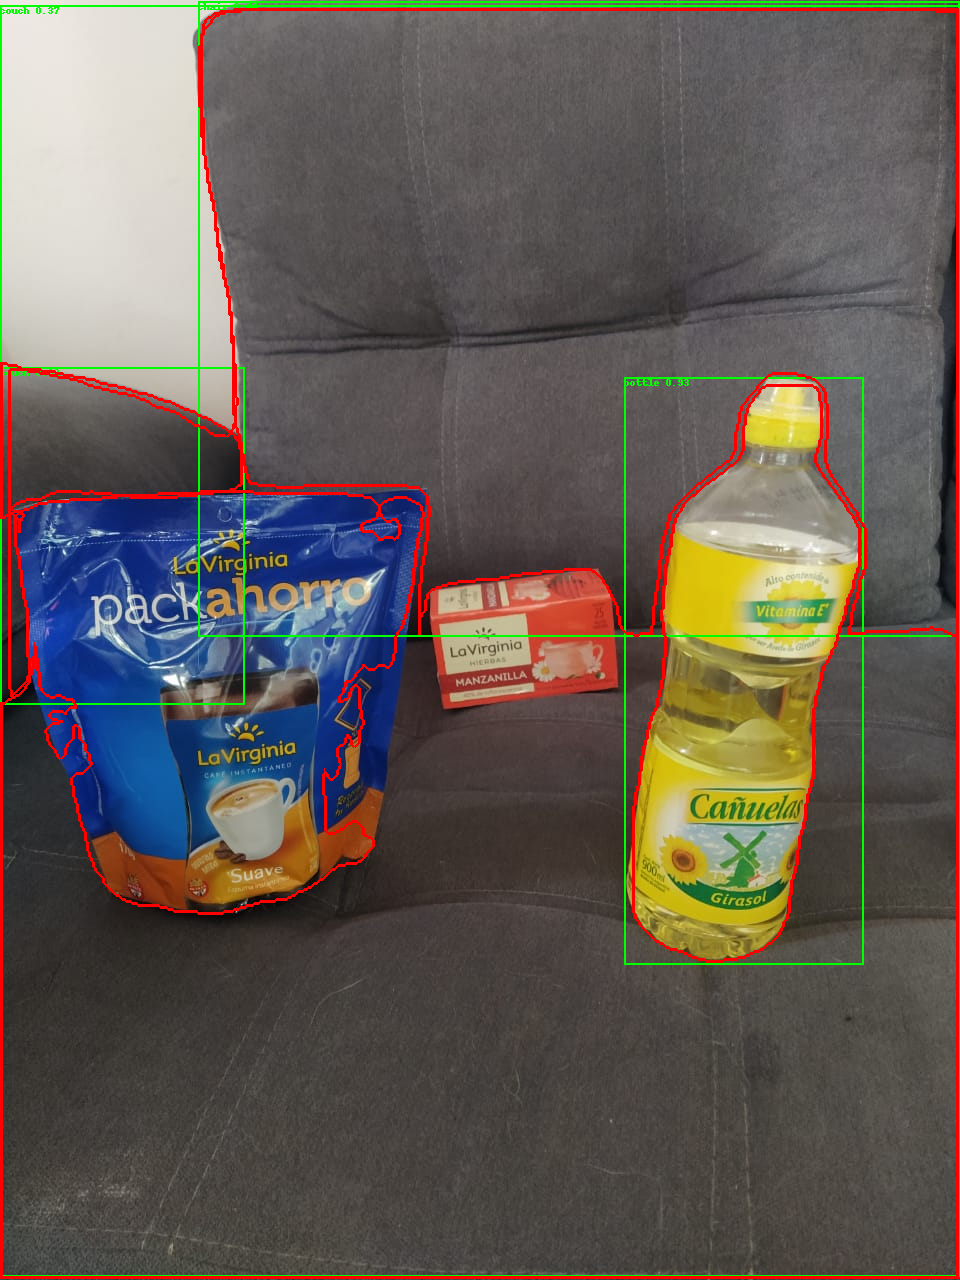

In [24]:
from ultralytics import YOLO
from PIL import Image, ImageDraw
import numpy as np
from IPython.display import display

# Cargar el modelo YOLOv8 con capacidad de segmentación
model = YOLO("yolov8m-seg.pt")

# Realizar predicciones en la imagen
results = model.predict('objetos5.jpeg')

# Seleccionar el primer resultado (en caso de que haya varios)
result = results[0]

# Abrir la imagen original para dibujar sobre ella
img = Image.open("objetos5.jpeg")
draw = ImageDraw.Draw(img)

# Para cada detección, dibujar el bounding box y mostrar la clase
for box in results[0].boxes:
    # Extracción de coordenadas del bounding box y clase
    x1, y1, x2, y2, conf, cls = box.data[0]
    label = result.names[int(cls)]  # Asumiendo que result.names contiene los nombres de las clases

    # Dibujar el bounding box
    draw.rectangle([x1, y1, x2, y2], outline=(0, 255, 0), width=2)

    # Mostrar la clase (y opcionalmente la confianza) en el bounding box
    text = f"{label} {conf:.2f}"
    draw.text((x1, y1), text, fill=(0, 255, 0))

# Acceder a las máscaras del resultado
masks = result.masks

# Iterar a través de todas las máscaras encontradas
for mask in masks:
    # Convertir la máscara a un array numpy y obtener el polígono
    mask_data = mask.data[0].numpy()
    polygon = mask.xy[0]

    # Dibujar el polígono correspondiente a cada máscara en la imagen original
    polygon_list = [(p[0], p[1]) for p in polygon]
    draw.polygon(polygon_list, outline=(255, 0, 0), width=3)

# Mostrar la imagen con los polígonos dibujados
display(img)

## Panoptic segmentation con modelo DETR ResNet50 (Transformers)

In [1]:
%%capture
!pip install timm

In [ ]:
!pip install transformers

In [3]:
import os

# Define tu token de Hugging Face
HF_TOKEN = "hf_xPFHuxscTPIRqraYCotlRuHEzrDqLBudgMI"

# Configura el token como una variable de entorno en Colab
os.environ["HF_HOME"] = "./.huggingface"  # Opcional: Define la carpeta de configuración de Hugging Face
os.environ["HF_TOKEN"] = HF_TOKEN

# Verifica si el token se ha configurado correctamente
print("Token de Hugging Face configurado correctamente.")


Token de Hugging Face configurado correctamente.


In [8]:
import requests
from PIL import Image, ImageDraw, ImageFont
import torch
import numpy as np
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
from transformers import DetrFeatureExtractor, DetrForSegmentation
from transformers.models.detr.feature_extraction_detr import rgb_to_id
import io

/usr/local/lib/python3.10/dist-packages/transformers/models/detr/feature_extraction_detr.py:38: FutureWarning: The class DetrFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DetrImageProcessor instead.
  warnings.warn(
Some weights of the model checkpoint at facebook/detr-resnet-50-panoptic were not used when initializing DetrForSegmentation: ['detr.model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are ini

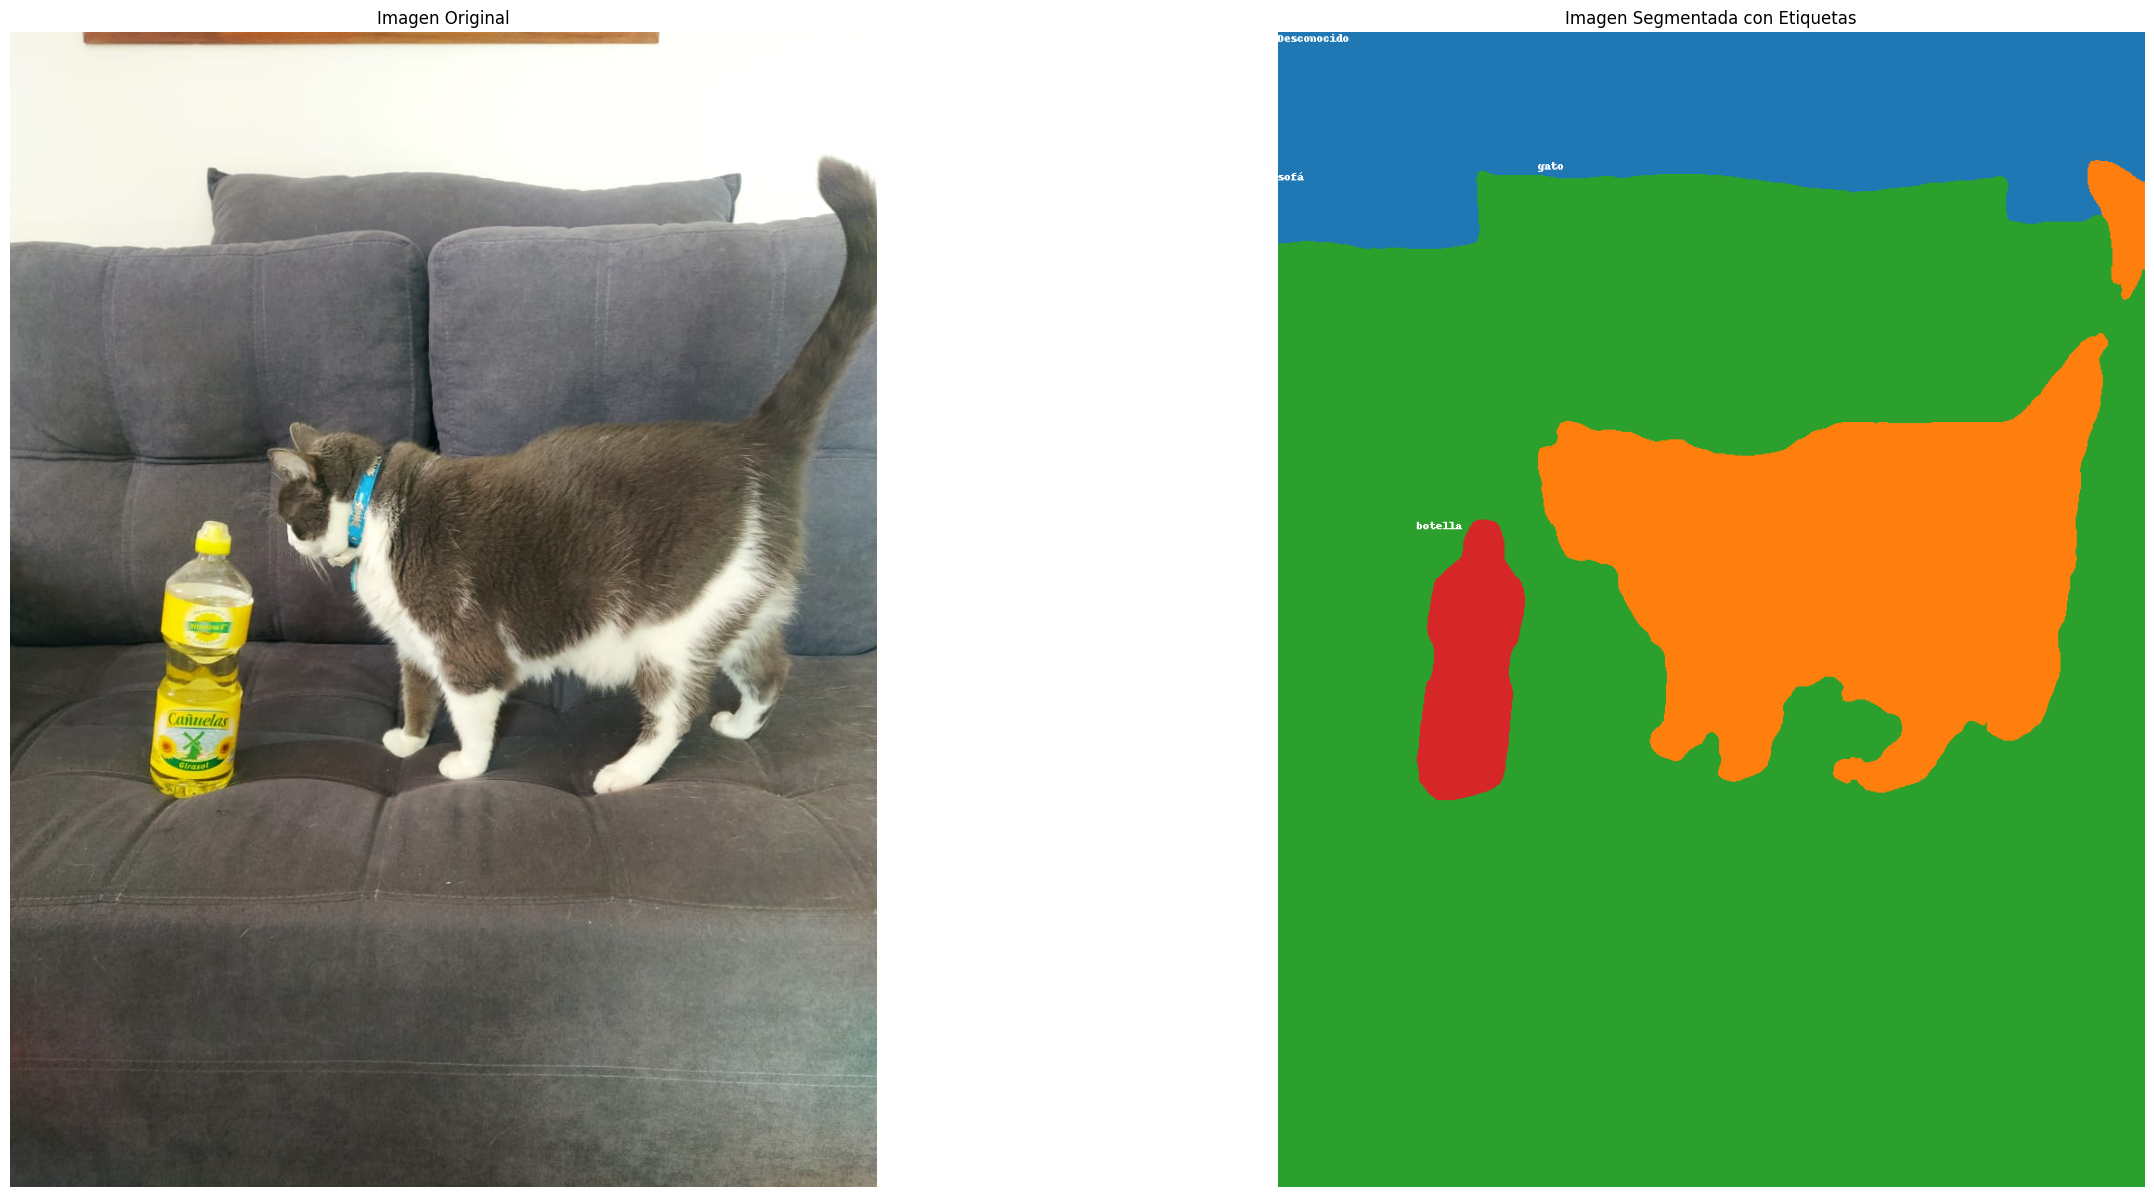

In [8]:


# Cargar la imagen

image = Image.open('objetos7.jpeg')

# Cargar el modelo y el extractor de características
feature_extractor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50-panoptic")
model = DetrForSegmentation.from_pretrained("facebook/detr-resnet-50-panoptic")

# Preparar la imagen para el modelo
inputs = feature_extractor(images=image, return_tensors="pt")

# Paso forward
outputs = model(**inputs)

# Postprocesamiento
processed_sizes = torch.as_tensor(inputs["pixel_values"].shape[-2:]).unsqueeze(0)
result = feature_extractor.post_process_panoptic(outputs, processed_sizes, threshold=0.85)[0]

# Convertir la segmentación a numpy
panoptic_seg = Image.open(io.BytesIO(result["png_string"]))
panoptic_seg = np.array(panoptic_seg, dtype=np.uint8)
panoptic_seg_id = rgb_to_id(panoptic_seg)

# Preparar la paleta de colores
palette = itertools.cycle(sns.color_palette())

# Crear la imagen segmentada
segmented_image = Image.fromarray(np.zeros_like(panoptic_seg, dtype=np.uint8))
draw = ImageDraw.Draw(segmented_image)

# Añadimos un mapeo manual de los IDs de las categorías a los nombres, basado en las clases comunes de COCO
COCO_LABELS = {
    1: 'persona', 2: 'bicicleta', 3: 'coche', 4: 'motocicleta', 5: 'avión',
    6: 'autobús', 7: 'tren', 8: 'camión', 9: 'barco', 10: 'semáforo',
    11: 'hidrante', 13: 'señal de stop', 14: 'parquímetro', 15: 'banco', 16: 'pájaro',
    17: 'gato', 18: 'perro', 19: 'caballo', 20: 'oveja', 21: 'vaca',
    22: 'elefante', 23: 'oso', 24: 'cebra', 25: 'jirafa', 27: 'mochila',
    28: 'paraguas', 31: 'bolso de mano', 32: 'corbata', 33: 'maleta', 34: 'frisbee',
    36: 'tabla de snowboard', 37: 'pelota deportiva', 38: 'cometa', 39: 'bate de béisbol',
    40: 'guante de béisbol', 41: 'patineta', 42: 'tabla de surf', 43: 'raqueta de tenis',
    44: 'botella', 46: 'plato de vino', 47: 'taza', 48: 'tenedor', 49: 'cuchillo',
    50: 'cuchara', 51: 'tazón', 52: 'banana', 53: 'manzana', 54: 'sándwich',
    55: 'naranja', 56: 'brócoli', 57: 'zanahoria', 58: 'perrito caliente', 59: 'pizza',
    60: 'donut', 61: 'pastel', 62: 'silla', 63: 'sofá', 64: 'maceta', 65: 'cama',
    67: 'mesa de comedor', 70: 'inodoro', 72: 'TV', 73: 'computadora portátil', 74: 'ratón',
    75: 'control remoto', 76: 'teclado', 77: 'teléfono celular', 78: 'microondas',
    79: 'horno', 80: 'tostadora', 81: 'fregadero', 82: 'refrigerador', 84: 'libro',
    85: 'reloj', 86: 'florero', 87: 'tijeras', 88: 'oso de peluche', 89: 'secador de pelo',
    90: 'cepillo de dientes', 91: 'caja', 92: 'botella'
}

# Ajusta el bucle para dibujar segmentos y etiquetas correctamente
for segment_info in result["segments_info"]:
    class_id = segment_info["category_id"]
    class_name = COCO_LABELS.get(class_id, 'Desconocido')  # 'Desconocido' si el ID no está en el diccionario
    id = segment_info["id"]

    # Generar la máscara para este segmento específico
    mask = panoptic_seg_id == id
    color = np.array(next(palette)) * 255  # Convertir el color a un array de numpy adecuado

    # Convertir la máscara a una imagen de PIL para usarla como máscara en 'paste'
    mask_image = Image.fromarray((mask * 255).astype(np.uint8))

    # Crear una imagen del color del segmento que tenga las dimensiones correctas
    color_image = Image.new("RGB", segmented_image.size, color=tuple(color.astype(int)))

    # Pegar usando la máscara para aplicar solo este segmento
    segmented_image.paste(color_image, (0,0), mask=mask_image)

    # Dibujar el nombre de la clase en la posición inicial del segmento
    draw = ImageDraw.Draw(segmented_image)
    where = np.where(mask)
    if where[0].size > 0 and where[1].size > 0:
        x, y = np.min(where[1]), np.min(where[0])
        draw.text((x, y), class_name, fill='white')

# Mostrar la imagen original y la segmentada
plt.figure(figsize=(30, 15))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Imagen Original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segmented_image)
plt.title('Imagen Segmentada con Etiquetas')
plt.axis('off')

plt.show()


EL modelo DETR ResNet50 (Transformers), dectecta la todo lso objetos pero no estaria dandole la ubicacon correcta a las etiquetas, ademas la segmentacion no es muy buena podemos ver como le corta la cola al gato. 

## SAM (Segment Anything Model)

In [1]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!{sys.executable} -m pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.2.1+cu121
Torchvision version: 0.17.1+cu121
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-ky93_pdn
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-ky93_pdn
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=7544d88f3c3912ce42075046e06653ff16ec701688ef26e3f90df8e0b3fc8a32
  Stored in directory: /tmp/pip-ephem-wheel-cache-y0_a0dkf/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.1/74.1 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

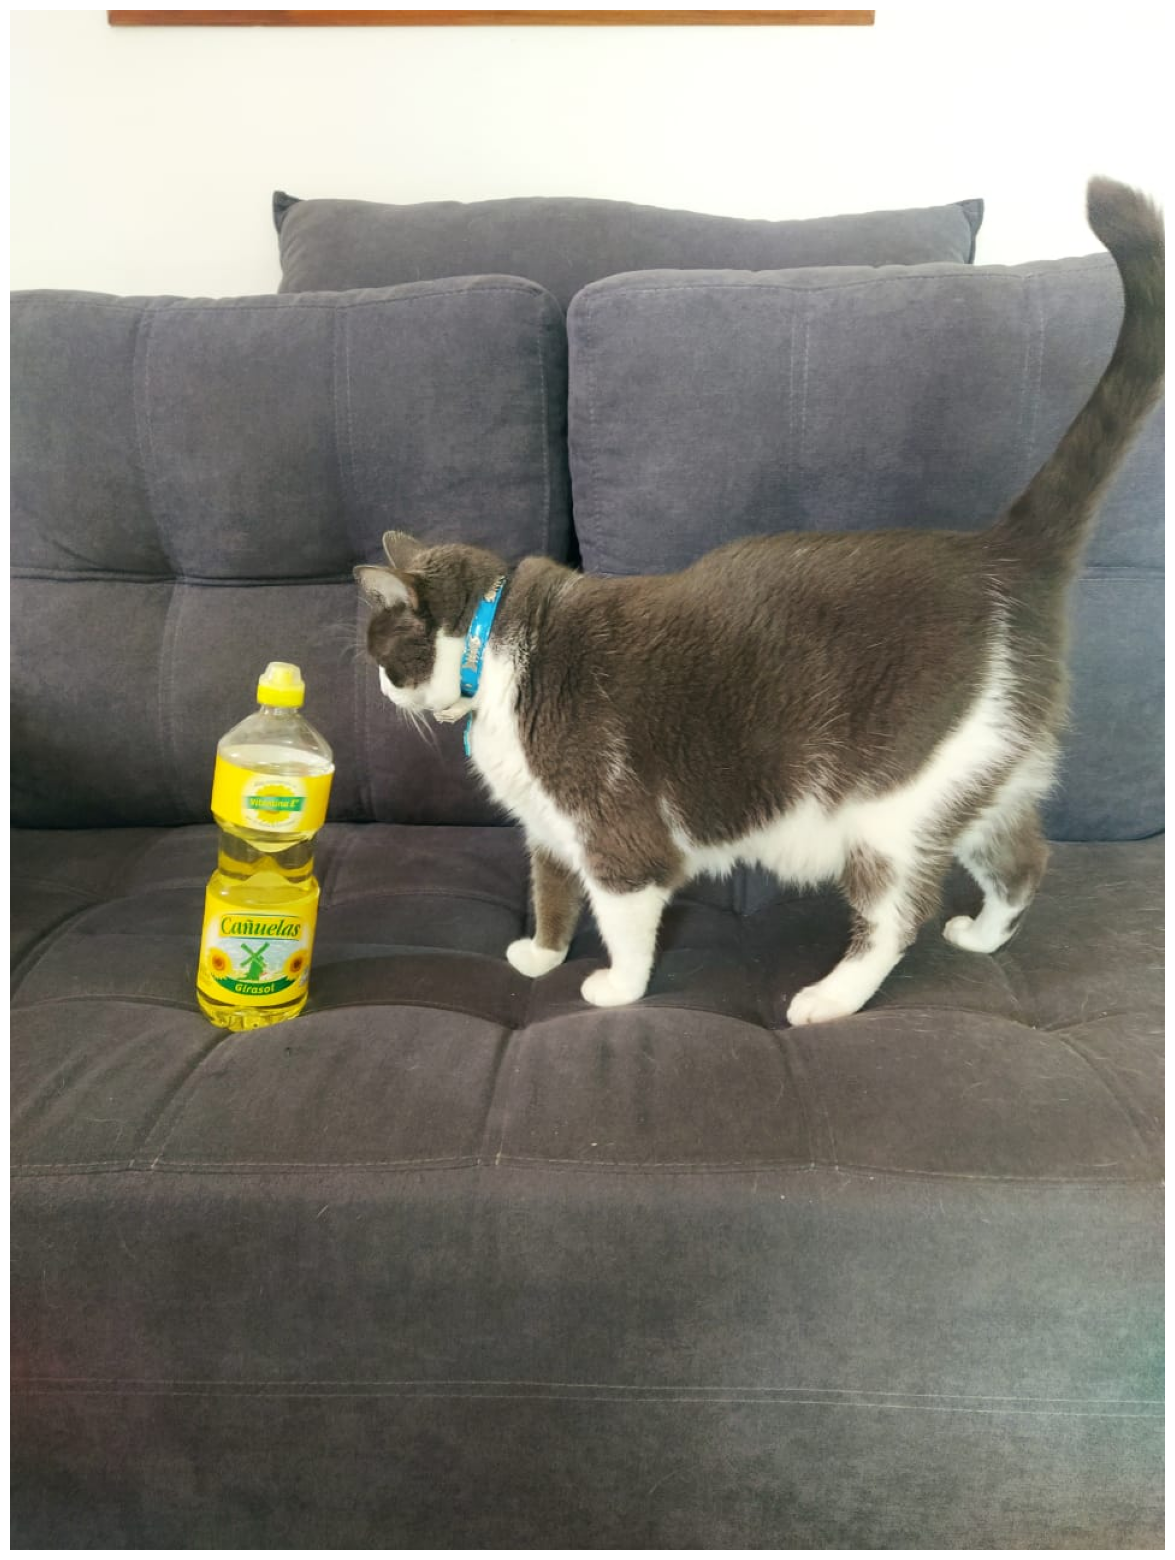

In [7]:
import matplotlib.pyplot as plt
import cv2
import matplotlib.pyplot as plt
import cv2

image = cv2.imread('/content/objetos7.jpeg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Función para mostrar la segmentación
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

30
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


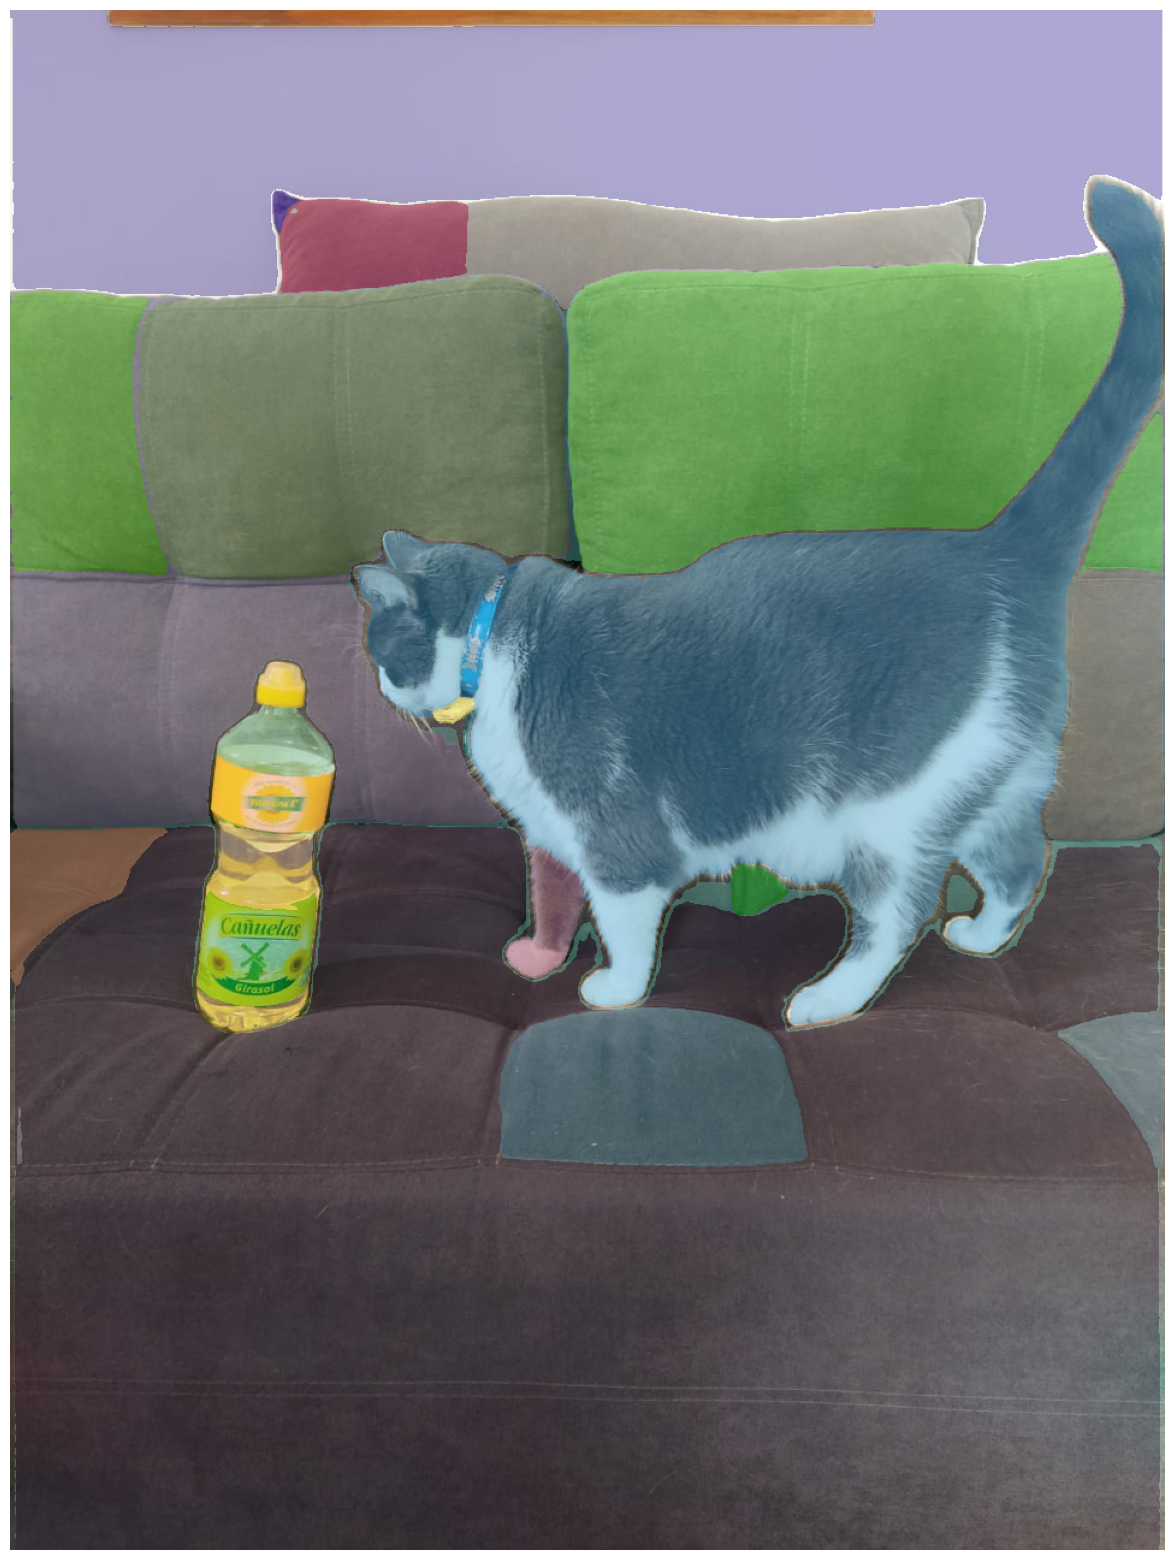

In [8]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

masks = mask_generator.generate(image)

print(len(masks))
print(masks[0].keys())

plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

El modelo SAM (Segment Anything Model), detecta muy bien la botella y el gato y la segmentacion es perfecta. 

CONCLUCION: Podemos ver que todos los modelos presentan su deficiencias al segmentar los objetos en la imagen, esto puede ser porque no esta entrenado con el objeto que esta en la foto como por ejemplo la caja de te que no la reconocieron los modelos, en cuanto al sofa creo que es mas dificil de segmentarlo porque la foto esta tomada muy de cerca pero aun asi los modelos los detectan e intentar segmentarlos. 